In [3]:

#import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, KFold, TimeSeriesSplit
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


#건물번호 지정
bnum = 20


In [7]:
# merged_train_df = pd.read_csv('./data/train_preprocessed_wsw.csv')
# test = merged_train_df.loc[(merged_train_df['building_number'] == 22) &(merged_train_df['week'] == 22) & (merged_train_df['day']==2)]
# test['max'] = np.max(test['power_consumption'])
# test['max'] = np.min(test['power_consumption'])

In [40]:
merged_train_df = pd.read_csv('./data/train_preprocessed_wsw_0729_3.csv',index_col=0)
test = merged_train_df.loc[merged_train_df.building_number==95]
test['building_number'] = 5


3.9252555182057134


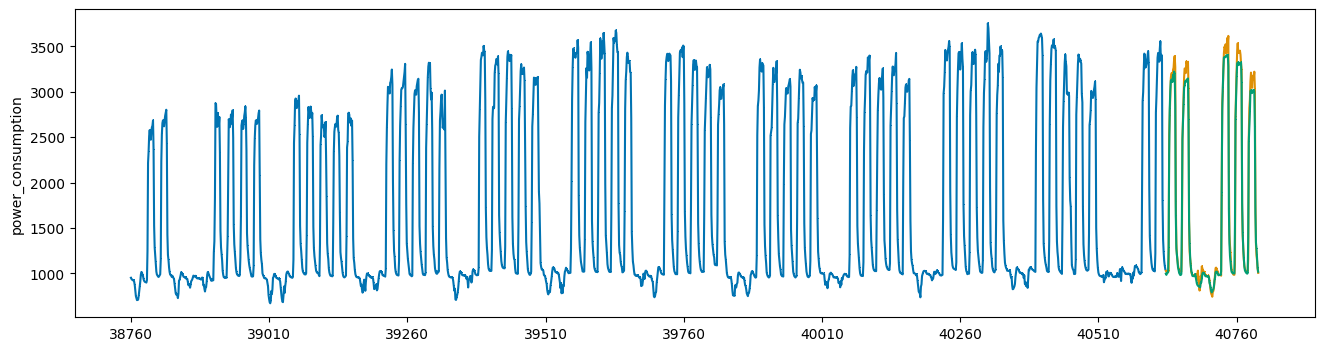

In [12]:
#불러오기
merged_train_df = pd.read_csv('./data/train_preprocessed_add_wsw.csv')
merged_train_df.drop(columns=['Unnamed: 0'],inplace= True)
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb_wsw.csv')
xgb_params.drop(columns=['Unnamed: 0'],inplace= True)
smape = []

y = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption']
x = merged_train_df.loc[merged_train_df.building_number == bnum, ].drop(columns=['power_consumption'])

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
## mse가중치 사용 O
xgb_reg = XGBRegressor(seed = 0, tree_method="hist",  gpu_id=0, n_estimators = xgb_params.iloc[bnum-1,7], eta = xgb_params.iloc[bnum-1, 1],
                min_child_weight = xgb_params.iloc[bnum-1, 2], max_depth = xgb_params.iloc[bnum-1, 3],
                colsample_bytree=xgb_params.iloc[bnum-1, 4], subsample=xgb_params.iloc[bnum-1, 5])
if xgb_params.iloc[bnum-1, 6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
        xgb_reg.set_params(**{'objective':weighted_mse(xgb_params.iloc[bnum-1,6])})

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],verbose=False)

pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])
smape.append(SMAPE(y_valid, pred))
#print('best iterations: {}'.format(xgb_reg.best_iteration))     
#print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

smape = np.array(smape)
print(smape.mean())

In [1]:
merged_train_df = pd.read_csv('./data/train_preprocessed_add_wsw_3.csv').drop(columns=['Unnamed: 0'])
merged_test_df = pd.read_csv('./data/test_preprocessed_add_wsw_3.csv').drop(columns=['Unnamed: 0'])


preds = xgb_reg.predict(merged_test_df)

fig, ax = plt.subplots(1, 1, figsize=(100,200), sharex = True)
ax = ax.flatten()
train_y = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption'].reset_index(drop = True)
test_y = preds[168:168]
ax[1].scatter(np.arange(2040) , train_y)
ax[1].scatter(np.arange(2040, 2040+168) , test_y)
ax[1].tick_params(axis='both', which='major', labelsize=6)
ax[1].tick_params(axis='both', which='minor', labelsize=4)

NameError: name 'pd' is not defined

하위 2개 칼럼 제거 smape평균: 4.128478910856373

칼럼 제거 안함 smape평균: 4.120167226270964

5.188400978121399


building_number: 0.0
temperature: 0.002593619516119361
rainfall: 0.002319990424439311
windspeed: 0.0026207626797258854
humidity: 0.0038493748288601637
hour: 0.005709700286388397
day: 0.006316335406154394
month: 0.011600627563893795
week: 0.14587309956550598
day_hour_mean: 0.479941189289093
hour_mean: 0.17755500972270966
hour_std: 0.030100470408797264
CDH: 0.007135543040931225
holiday: 0.008760196156799793
sin_time: 0.006114864721894264
cos_time: 0.00599376717582345
THI: 0.006836015731096268
cooling_to_total_area_ratio: 0.0
max_power: 0.07388406246900558
min_power: 0.022795455530285835
solar_to_ess_ratio: 0.0


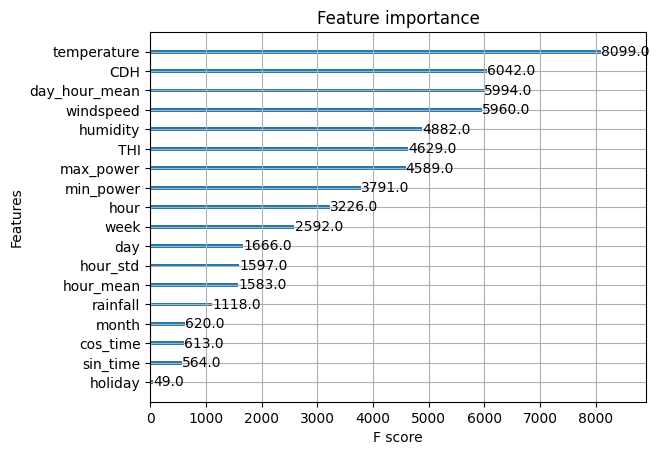

In [5]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 피처 중요도 확인
feature_importances = xgb_reg.feature_importances_

# 피처 중요도를 출력합니다.(위에서 5개만)
for i, feat_importance in enumerate(feature_importances):
  print(f"{x.columns[i]}: {feat_importance}")

# 피처 중요도를 시각화합니다.
xgb.plot_importance(xgb_reg)
plt.show()

iterations: 가중치 편향 업데이트 횟수, 이값으로 과적합을 방지 할 수 있음

best iterations: 202
SMAPE : 76.72719822088945


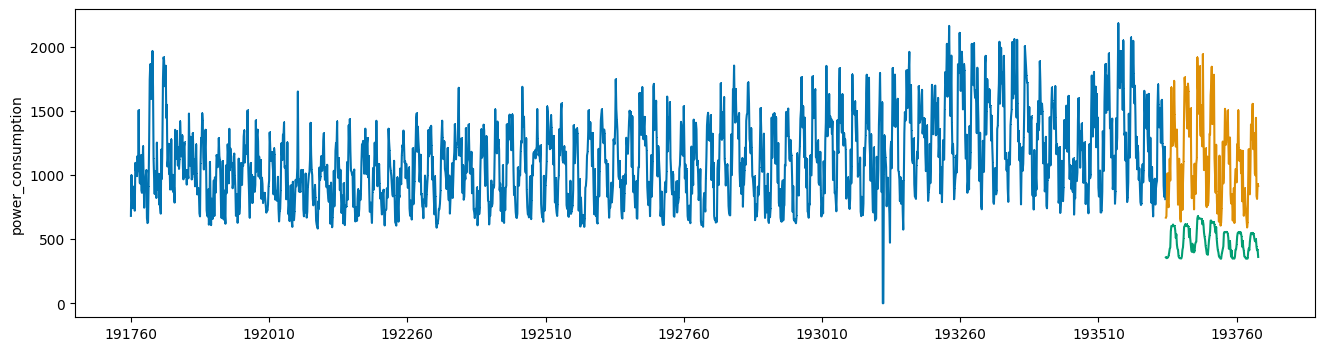

In [58]:
#불러오기
merged_train_df = pd.read_csv('./data/train_preprocessed_add_wsw.csv')
merged_train_df.drop(columns=['Unnamed: 0'],inplace= True)
merged_train_df.head()
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb_wsw.csv')
xgb_params.drop(columns=['Unnamed: 0'],inplace= True)
#추가 전처리
merged_train_df['power_consumption'] = np.log1p(merged_train_df['power_consumption'])

y = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption']
x = merged_train_df.loc[merged_train_df.building_number == bnum, ].drop(columns=['power_consumption'])
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

## mse가중치 사용 O
xgb_reg = XGBRegressor(seed = 0, tree_method="hist",  gpu_id=0, n_estimators = xgb_params.iloc[bnum-1,7], eta = xgb_params.iloc[bnum-1, 1],
                           min_child_weight = xgb_params.iloc[bnum, 2], max_depth = xgb_params.iloc[bnum-1, 3],
                           colsample_bytree=xgb_params.iloc[bnum-1, 4], subsample=xgb_params.iloc[bnum-1, 5])
if xgb_params.iloc[bnum-1, 6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
        xgb_reg.set_params(**{'objective':weighted_mse(xgb_params.iloc[bnum-1,6])})

xgb_reg.set_params(**{'objective':weighted_mse(100)})

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

y_train =np.expm1(y_train)
y_valid =np.expm1(y_valid)

pred = xgb_reg.predict(x_valid)
pred = np.expm1(pred)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

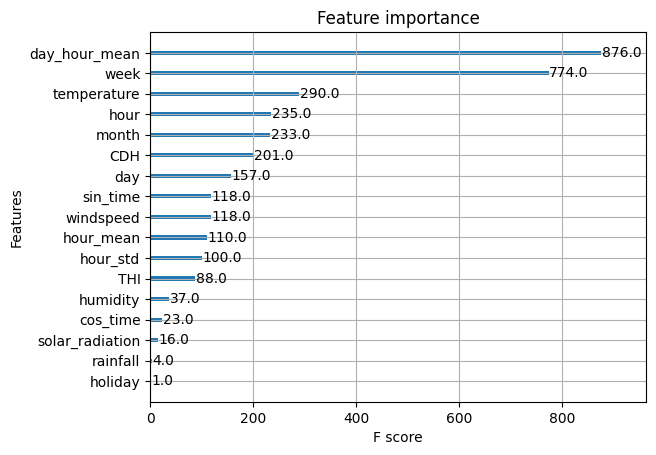

In [41]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 피처 중요도 확인
feature_importances = xgb_reg.feature_importances_

# # 피처 중요도를 출력합니다.(위에서 5개만)
# for i, feat_importance in enumerate(feature_importances):
#   print(f"Feature {i}: {feat_importance}")

# 피처 중요도를 시각화합니다.
xgb.plot_importance(xgb_reg)
plt.show()